# Домашнее задание


In [165]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, power_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# 1. Загрузка данных

In [166]:
data = pd.read_csv('train.csv')

In [167]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [169]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2073,7,49.75,331.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,No,No,No,No,One year,Yes,Electronic check,1
3102,5,69.95,320.4,Female,0,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Credit card (automatic),0
1965,14,64.70,941,Female,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),1
4854,23,79.15,1676.95,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,1
1565,19,78.25,1490.95,Male,0,No,No,Yes,No,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,1


Поле TotalSpent записано как object, хотя на самом деле это число. Преобразуем...

In [170]:
data['TotalSpent'] = pd.to_numeric(data.TotalSpent.str.strip())

Теперь посмотрим на пропуски...

In [171]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [172]:
data[data['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [173]:
data.query('ClientPeriod == 1')[['TotalSpent', 'MonthlySpending']]

,TotalSpent,MonthlySpending
2,75.90,75.90
7,45.70,45.70
51,74.45,74.45
63,48.45,48.45
67,24.40,24.40
...,...,...
5192,69.65,69.65
5199,19.70,19.70
5257,19.20,19.20
5265,85.80,85.80


NaN в TotalSpending - это новые клиенты. Можно заменить NaN на 0 или иное какое малое число, например, на половину от месячных расходов. 
Заполним пропуски, а потом посмотрим на дубликаты:

In [174]:
#заполним половиной месячного расхода
data.loc[data['TotalSpent'].isna(), 'TotalSpent'] = data.loc[data['TotalSpent'].isna(), 'MonthlySpending'] /2
data[data.ClientPeriod == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,12.875,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,36.675,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,9.850,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,40.425,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,10.000,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,30.950,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,12.675,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,26.275,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,28.025,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [175]:
data.duplicated().sum() #есть 14 полностью дублированных строк. Удалим их (дубли).

14

In [176]:
data.drop_duplicates(inplace=True)

#теперь посмотрим, не осталось ли дубликатов, если отбросить целевой признак.
data[data.drop(['Churn'], axis=1).duplicated(keep=False)].sort_values(by=[*data.columns])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4811,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3463,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4294,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3831,1,20.00,20.00,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1647,1,20.00,20.00,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3735,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
3769,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
881,1,20.40,20.40,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1874,1,20.40,20.40,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1


Осталось еще несколько дубликатов, различающихся по целевому признаку. Вся путаница в первом месяце, причем запись с Churn=1 позже, т.е. можно предположить, что информация о покупке еще не убрана из базы. Т.е. лучше оставить записи с Churn=1.

In [177]:
data.drop_duplicates(subset=list(data.columns[:-1]), keep='last', inplace=True)

Заметим, что признак IsSeniorCitizen хранится как число, хотя по сути он категориальный. 
Но это не мешает.

Посмотрим базовые статистики по столбцам

In [178]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5260.000000,5260.000000,5260.000000,5260.000000,5260.000000
mean,32.528327,65.040875,2296.937662,0.159886,0.260646
std,24.517317,30.153470,2269.067506,0.366535,0.439029
min,0.000000,18.250000,9.850000,0.000000,0.000000
25%,9.000000,35.737500,403.300000,0.000000,0.000000
50%,29.000000,70.500000,1414.900000,0.000000,0.000000
75%,55.000000,90.050000,3813.712500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


In [179]:
data.describe(include=['O'])

,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2644,2683,3654,4739,2489,2335,2603,2323,2308,2595,2090,2072,2898,3139,1780


Больше никаких аномалий в данных на этом этапе не заметно.

## Анализ данных


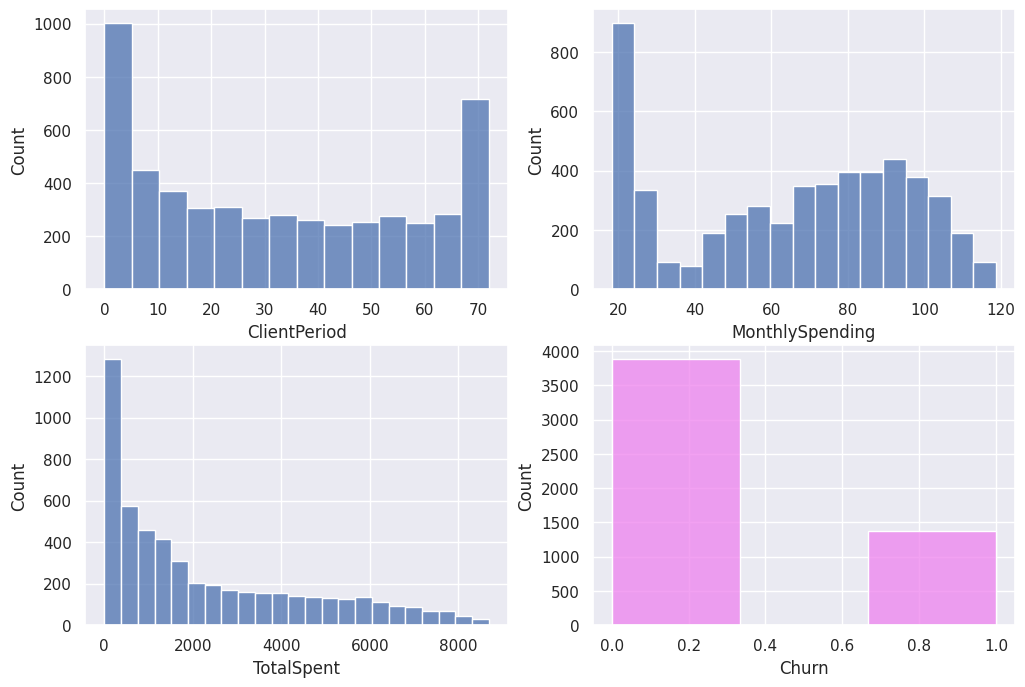

In [180]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot( x=col, data=data)

plt.subplot(2, 2, 4)
sns.histplot( x='Churn', data=data, color='violet', bins=3);

**Посмотрим на целевую переменную:** 
(сиренево-фиолетовый график). Таки да, классы слегка разбалансированы, ушедших абонентов примерно в три раза меньше, чем остающихся. Но это не тот дисбаланс, к которому надо применять специальные методы обработки.

Видно, что по параметру TotalSpent очень большой разброс. Есть две идеи:
1. Добавить колонку с логарифмом этого параметра (и прибавить 1 для отрыва от нуля), 
2. Разделить его на ClientPeriod.  

Посмотрим оба варианта:

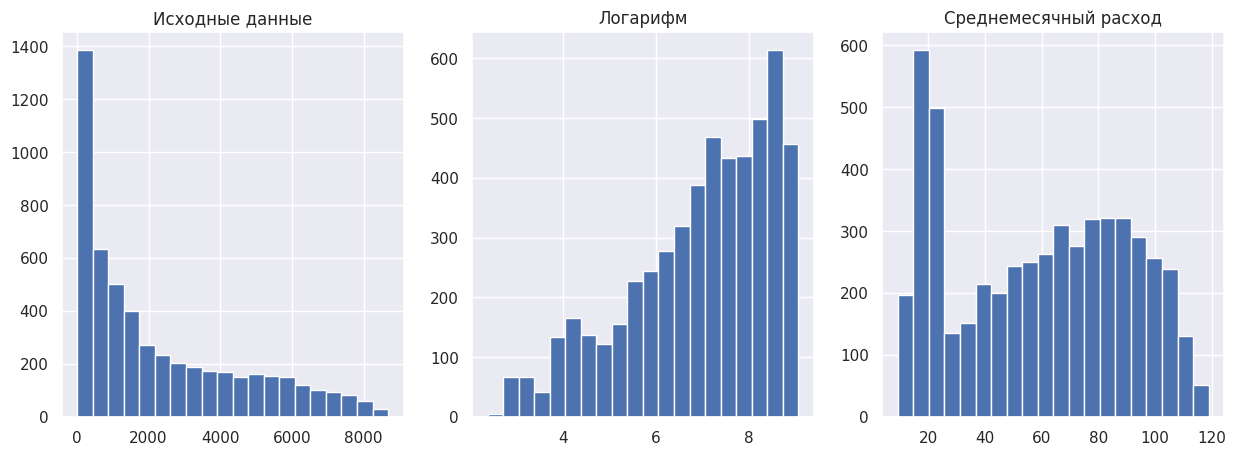

In [181]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)         
plt.hist(data.TotalSpent, bins=20)
plt.title('Исходные данные')           
plt.subplot(1, 3, 2)         
plt.hist(np.log1p(data.TotalSpent), bins=20)
plt.title('Логарифм')           
plt.subplot(1, 3, 3)           
plt.hist(data.TotalSpent/(data.ClientPeriod + 1), bins=20);
plt.title('Среднемесячный расход');

## Применение линейных моделей
Оба варианта выглядят привлекательно. Поставим эксперимент на простейшей логистической регрессии:

In [182]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Churn'], axis='columns'), data['Churn'], 
                                                    test_size=0.2, random_state=1968)

In [183]:
def lr_try(X_train, X_test, y_train, y_test, num_cols):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train[num_cols], y_train)
    X_test_s = scaler.transform(X_test[num_cols])

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='if_binary')
    X_train_e = ohe.fit_transform(X_train[cat_cols], y_train)
    X_test_e = ohe.transform(X_test[cat_cols])

    # полная матрица
    X_train_trans = np.concatenate([X_train_s, X_train_e], axis=1)
    X_test_trans = np.concatenate([X_test_s, X_test_e], axis=1)

    lr = LogisticRegression()
    lr.fit( X_train_trans, y_train)
    y_train_predict = lr.predict_proba(X_train_trans)
    y_test_predict = lr.predict_proba(X_test_trans)

    return roc_auc_score(y_train, y_train_predict[:,1]), roc_auc_score(y_test, y_test_predict[:,1]) 

#Исходная таблица, baseline

#X_train_s = X_train.copy()

print("ROC_AUC test, train:", * lr_try(X_train, X_test, y_train, y_test, num_cols))

ROC_AUC test, train: 0.8426309932130049 0.871630197972909


In [184]:
#Логарифм

X_train_s, X_test_s = X_train.copy(), X_test.copy()
X_train_s['TotalSpentLog'] = np.log(X_train.TotalSpent)
X_test_s['TotalSpentLog'] = np.log(X_test.TotalSpent)

print("ROC_AUC test, train:", * lr_try(X_train_s, X_test_s, y_train, y_test, num_cols+['TotalSpentLog']))

ROC_AUC test, train: 0.8455306014048732 0.8799374822392726


In [185]:
#Среднемесячный расход

X_train_s, X_test_s = X_train.copy(), X_test.copy()
X_train_s['TotalSpent'] = X_train.TotalSpent / (X_train.ClientPeriod+1)
X_test_s['TotalSpent'] = X_test.TotalSpent / (X_test.ClientPeriod+1)

print("ROC_AUC test, train:", * lr_try(X_train_s, X_test_s, y_train, y_test, num_cols))

ROC_AUC test, train: 0.8428923350542724 0.8753812636165578


**Наилучший вариант - с логарифмом. Но добавим оба! И еще прологарифмируем MonthlySpending**

In [186]:
data['TotalSpentLog'] = np.log(data['TotalSpent']) #добавили параметр TotalSpentLog на его логарифм.
data['MonSpentLog'] = np.log1p(data['MonthlySpending'])
data['TotalSpentMean'] = data.TotalSpent / (data.ClientPeriod+1)
num_cols = list(set(num_cols+['TotalSpentLog', 'MonSpentLog', 'TotalSpentMean']))
num_cols

['MonSpentLog',
 'TotalSpent',
 'MonthlySpending',
 'TotalSpentMean',
 'ClientPeriod',
 'TotalSpentLog']

Ну, и посмотрим корреляцию между признаками.

In [187]:
data.corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,TotalSpentLog,MonSpentLog,TotalSpentMean
ClientPeriod,1.000000,0.246033,0.825869,0.009938,-0.349151,0.832753,0.196349,0.409658
MonthlySpending,0.246033,1.000000,0.651366,0.214500,0.187049,0.574236,0.977437,0.958281
TotalSpent,0.825869,0.651366,1.000000,0.093610,-0.198124,0.832266,0.587052,0.763642
IsSeniorCitizen,0.009938,0.214500,0.093610,1.000000,0.158100,0.098127,0.213164,0.195189
Churn,-0.349151,0.187049,-0.198124,0.158100,1.000000,-0.234945,0.206477,0.070554
TotalSpentLog,0.832753,0.574236,0.832266,0.098127,-0.234945,1.000000,0.544738,0.744649
MonSpentLog,0.196349,0.977437,0.587052,0.213164,0.206477,0.544738,1.000000,0.922333
TotalSpentMean,0.409658,0.958281,0.763642,0.195189,0.070554,0.744649,0.922333,1.000000


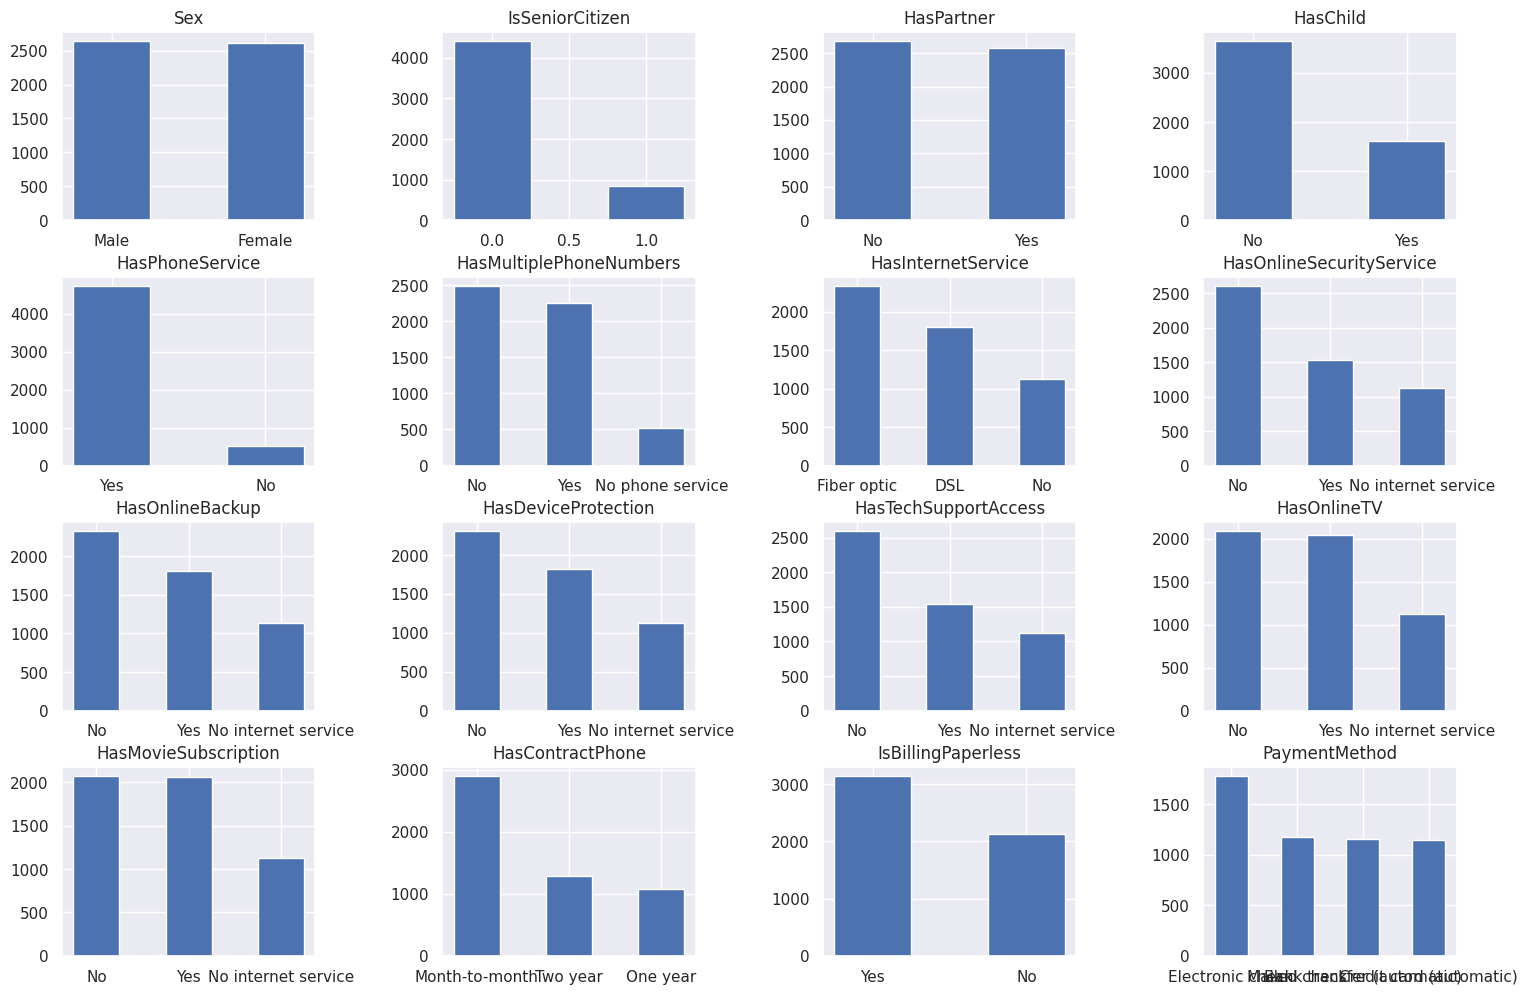

In [188]:
sns.set()

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols):
    plotdata = data[col].value_counts()
    plt.subplot(4, 4, i+1)
    plt.bar(plotdata.index, plotdata.values, width=0.5)
    plt.title(col)
    
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();    

**На этом этапе ошибок и выбросов также не видно.**

Посмотрим еще зависимость целевого признака от категориальных признаков:

In [189]:
col = cat_cols[3]
pdata = data[data['Churn']==1][col].value_counts() / data[col].value_counts() #.sort_values(ascending=False)
pdata = pdata.sort_values(ascending=False)
pdata

No     0.307882
Yes    0.153176
Name: HasChild, dtype: float64

In [190]:
pdata.sort_values(ascending=False)

No     0.307882
Yes    0.153176
Name: HasChild, dtype: float64

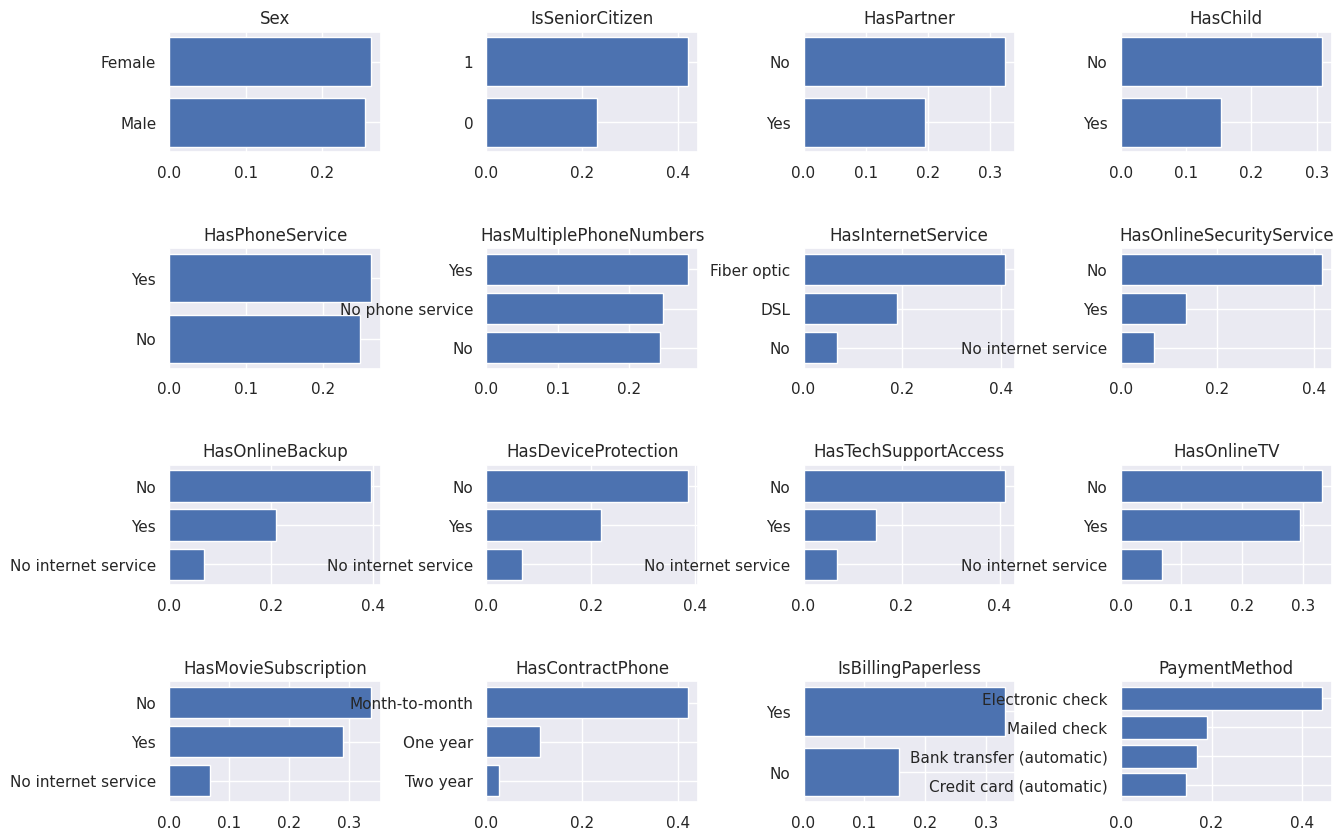

In [191]:
plt.figure(figsize=(15, 10))
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)
for i, col in enumerate(cat_cols):
    pdata=data[data['Churn']==1][col].value_counts() / data[col].value_counts()
    pdata = pdata.sort_values()# (ascending=False)
    plt.subplot(4, 4, i+1)
    plt.barh(pdata.index, width=pdata.values)
    plt.title(col)
    
plt.show();    


Видны категории, в которых процент "отказников" значительно выше: это PaymentMethod:Electronic check, HasContractPhone:Month-to-month, ну и еще пара категорий. Если бы у нас была задача определить, чем клиенты недовольны - надо было бы исследовать дальше в этом направлении.

**На этом предварительную обработку данных закончим.**

**Хотя можно было бы заняться конструированием новых фичей.**

# 2. Загрузка и обработка тестовых данных

In [192]:
test_data = pd.read_csv('test.csv')

In [193]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [194]:
#повторяем обработку, примененную для Train
test_data['TotalSpent'] = pd.to_numeric(test_data.TotalSpent.str.strip())
test_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  2
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

In [195]:
#заполним половиной месячного расхода
test_data.loc[test_data['TotalSpent'].isna(), 'TotalSpent'] = test_data.loc[test_data['TotalSpent'].isna(), 'MonthlySpending'] /2
test_data[test_data.ClientPeriod == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,9.925,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,10.125,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [196]:
# добавим логирифмированные фичи и среднее
test_data['TotalSpentLog'] = np.log(test_data['TotalSpent'])
test_data['MonSpentLog'] = np.log1p(test_data['MonthlySpending'])
test_data['TotalSpentMean'] = test_data.TotalSpent / (test_data.ClientPeriod+1)

In [197]:
test_data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,TotalSpentLog,MonSpentLog,TotalSpentMean
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,32.293583,64.272601,2256.494520,0.170358,6.917553,4.036474,58.530204
std,24.593736,29.832517,2260.490448,0.376054,1.566571,0.579138,30.304122
min,0.000000,18.550000,9.925000,0.000000,2.295057,2.972975,9.425000
25%,9.000000,35.650000,405.600000,0.000000,6.005367,3.601413,26.750000
50%,29.000000,70.050000,1356.300000,0.000000,7.212516,4.263384,60.550000
75%,56.000000,89.400000,3759.050000,0.000000,8.231922,4.504244,83.944565
max,72.000000,117.350000,8496.700000,1.000000,9.047433,4.773646,116.393151


### Тестовые данные загружены и подготовлены.

## Применение линейных моделей

# 3. Логистическая регрессия

In [198]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

lrmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', LogisticRegression(max_iter=200))
])

params = {
    'alg__C':np.linspace(0.08, 0.15, 20), #[0.01, 0.1, 1, 10, 100],
    'alg__penalty':['l1'], # 'l2'], 
    'alg__solver':['saga'] # ['lbfgs', 'liblinear', 'saga']
}

lr = GridSearchCV(lrmodel, params, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc')

lr.fit(data.drop(target_col, axis='columns'), data[target_col])
lr.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START alg__C=0.08, alg__penalty=l1, alg__solver=saga.............


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 1/20] START alg__C=0.08, alg__penalty=l1, alg__solver=saga.............
[CV 2/5; 1/20] START alg__C=0.08, alg__penalty=l1, alg__solver=saga.............
[CV 3/5; 1/20] START alg__C=0.08, alg__penalty=l1, alg__solver=saga.............
[CV 4/5; 1/20] START alg__C=0.08, alg__penalty=l1, alg__solver=saga.............
[CV 1/5; 1/20] END alg__C=0.08, alg__penalty=l1, alg__solver=saga;, score=0.865 total time=   0.3s
[CV 3/5; 3/20] START alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga
[CV 3/5; 2/20] START alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 2/20] START alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga
[CV 1/5; 2/20] START alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga
[CV 5/5; 1/20] END alg__C=0.08, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.3s
[CV 2/5; 1/20] END alg__C=0.08, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.3s
[CV 3/5; 1/20] END alg__C=0.08, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.3s
[CV 4/5; 3/20] START alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga
[CV 1/5; 3/20] START alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga
[CV 5/5; 3/20] START alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga
[CV 1/5; 4/20] START alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga
[CV 3/5; 3/20] END alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.3s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 4/20] START alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga
[CV 4/5; 2/20] START alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga
[CV 2/5; 3/20] START alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga
[CV 5/5; 2/20] START alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga
[CV 3/5; 2/20] END alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.3s
[CV 1/5; 2/20] END alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga;, score=0.865 total time=   0.3s
[CV 3/5; 4/20] START alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga
[CV 4/5; 4/20] START alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga
[CV 2/5; 2/20] END alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.4s
[CV 4/5; 1/20] END alg__C=0.08, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.5s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 4/20] END alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 5/5; 3/20] END alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.2s
[CV 5/5; 4/20] START alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga
[CV 1/5; 5/20] START alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga
[CV 1/5; 3/20] END alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga;, score=0.865 total time=   0.3s
[CV 2/5; 5/20] START alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga
[CV 1/5; 4/20] END alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga;, score=0.865 total time=   0.3s
[CV 3/5; 5/20] START alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga
[CV 4/5; 5/20] START alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga
[CV 2/5; 3/20] END alg__C=0.08736842105263158, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.3s
[CV 5/5; 5/20] 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse


[CV 5/5; 6/20] START alg__C=0.09842105263157895, alg__penalty=l1, alg__solver=saga
[CV 5/5; 4/20] END alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.3s
[CV 4/5; 2/20] END alg__C=0.08368421052631579, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.5s
[CV 1/5; 7/20] START alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga
[CV 3/5; 5/20] END alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.3s
[CV 2/5; 7/20] START alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga
[CV 2/5; 6/20] END alg__C=0.09842105263157895, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 3/5; 7/20] START alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga
[CV 1/5; 6/20] END alg__C=0.09842105263157895, alg__penalty=l1, alg__solver=saga;, score=0.865 total time=   0.2s
[CV 4/5; 4/20] END alg__C=0.09105263157894737, alg__penalty=l1, alg__solver=saga;, score=0.857 to

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 6/20] END alg__C=0.09842105263157895, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.2s
[CV 4/5; 5/20] END alg__C=0.09473684210526316, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.4s
[CV 5/5; 8/20] START alg__C=0.10578947368421052, alg__penalty=l1, alg__solver=saga
[CV 1/5; 9/20] START alg__C=0.1094736842105263, alg__penalty=l1, alg__solver=saga
[CV 2/5; 7/20] END alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 3/5; 7/20] END alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.2s
[CV 2/5; 9/20] START alg__C=0.1094736842105263, alg__penalty=l1, alg__solver=saga
[CV 3/5; 9/20] START alg__C=0.1094736842105263, alg__penalty=l1, alg__solver=saga
[CV 1/5; 7/20] END alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.3s
[CV 4/5; 9/20] START alg__C=0.1094736842105263, alg__penalty=l1, alg__solver=saga
[CV 4/5; 6/20] END 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 8/20] END alg__C=0.10578947368421052, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.3s
[CV 5/5; 7/20] END alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.3s
[CV 1/5; 10/20] START alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga
[CV 5/5; 8/20] END alg__C=0.10578947368421052, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.2s
[CV 2/5; 8/20] END alg__C=0.10578947368421052, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.3s
[CV 2/5; 10/20] START alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga
[CV 3/5; 10/20] START alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga
[CV 1/5; 8/20] END alg__C=0.10578947368421052, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.4s
[CV 4/5; 10/20] START alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga
[CV 4/5; 7/20] END alg__C=0.10210526315789473, alg__penalty=l1, alg__solver=saga;, score=0.857 tot

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 12/20] START alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga
[CV 3/5; 10/20] END alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga;, score=0.842 total time=   0.2s
[CV 2/5; 12/20] START alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga
[CV 2/5; 10/20] END alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.3s
[CV 3/5; 12/20] START alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga
[CV 2/5; 11/20] END alg__C=0.11684210526315789, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 4/5; 12/20] START alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga
[CV 4/5; 9/20] END alg__C=0.1094736842105263, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.4s
[CV 5/5; 12/20] START alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga
[CV 5/5; 10/20] END alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.3s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 13/20] START alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga
[CV 3/5; 11/20] END alg__C=0.11684210526315789, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 2/5; 13/20] START alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga
[CV 5/5; 11/20] END alg__C=0.11684210526315789, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.3s
[CV 1/5; 10/20] END alg__C=0.1131578947368421, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.4s
[CV 3/5; 13/20] START alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga
[CV 2/5; 12/20] END alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 4/5; 13/20] START alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga
[CV 5/5; 13/20] START alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga
[CV 1/5; 11/20] END alg__C=0.11684210526315789, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.4s
[CV 1/

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 14/20] START alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga
[CV 2/5; 13/20] END alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 1/5; 12/20] END alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.4s
[CV 5/5; 14/20] START alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga
[CV 4/5; 11/20] END alg__C=0.11684210526315789, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.5s
[CV 1/5; 15/20] START alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga
[CV 2/5; 15/20] START alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga
[CV 3/5; 13/20] END alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.3s
[CV 4/5; 12/20] END alg__C=0.12052631578947368, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.4s
[CV 3/5; 15/20] START alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga
[CV 4

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 14/20] END alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 2/5; 14/20] END alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.3s
[CV 5/5; 13/20] END alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.4s
[CV 5/5; 15/20] START alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga
[CV 1/5; 16/20] START alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga
[CV 2/5; 16/20] START alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga
[CV 4/5; 13/20] END alg__C=0.12421052631578947, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.4s
[CV 3/5; 16/20] START alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga
[CV 2/5; 15/20] END alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 4/5; 16/20] START alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga
[CV 1

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 17/20] START alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga
[CV 2/5; 16/20] END alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 3/5; 17/20] START alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga
[CV 5/5; 14/20] END alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.5s
[CV 4/5; 17/20] START alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga
[CV 3/5; 16/20] END alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 5/5; 17/20] START alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga
[CV 1/5; 15/20] END alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.5s
[CV 1/5; 18/20] START alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga
[CV 4/5; 14/20] END alg__C=0.12789473684210526, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.6s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 18/20] START alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga
[CV 5/5; 15/20] END alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.4s
[CV 2/5; 17/20] END alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 4/5; 18/20] START alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga
[CV 3/5; 18/20] START alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga
[CV 3/5; 17/20] END alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 5/5; 18/20] START alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga
[CV 5/5; 16/20] END alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.4s
[CV 4/5; 15/20] END alg__C=0.13157894736842105, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.6s
[CV 1/5; 19/20] START alg__C=0.1463157894736842, alg__penalty=l1, alg__solver=saga
[CV 2/

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 18/20] END alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 3/5; 19/20] START alg__C=0.1463157894736842, alg__penalty=l1, alg__solver=saga
[CV 1/5; 16/20] END alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.6s
[CV 4/5; 19/20] START alg__C=0.1463157894736842, alg__penalty=l1, alg__solver=saga
[CV 1/5; 17/20] END alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.5s
[CV 3/5; 18/20] END alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 5/5; 19/20] START alg__C=0.1463157894736842, alg__penalty=l1, alg__solver=saga
[CV 4/5; 16/20] END alg__C=0.13526315789473684, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.6s
[CV 1/5; 20/20] START alg__C=0.15, alg__penalty=l1, alg__solver=saga............
[CV 2/5; 20/20] START alg__C=0.15, alg__penalty=l1, alg__solver=saga............
[CV 5/5; 17/20

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 19/20] END alg__C=0.1463157894736842, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 5/5; 20/20] START alg__C=0.15, alg__penalty=l1, alg__solver=saga............
[CV 4/5; 17/20] END alg__C=0.13894736842105262, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.6s
[CV 2/5; 20/20] END alg__C=0.15, alg__penalty=l1, alg__solver=saga;, score=0.843 total time=   0.2s
[CV 5/5; 18/20] END alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga;, score=0.840 total time=   0.5s
[CV 3/5; 20/20] END alg__C=0.15, alg__penalty=l1, alg__solver=saga;, score=0.841 total time=   0.2s
[CV 1/5; 18/20] END alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.7s
[CV 4/5; 18/20] END alg__C=0.14263157894736841, alg__penalty=l1, alg__solver=saga;, score=0.857 total time=   0.6s
[CV 1/5; 20/20] END alg__C=0.15, alg__penalty=l1, alg__solver=saga;, score=0.866 total time=   0.4s
[CV 5/5; 19/20] END alg__C=0.1463157894736842

{'alg__C': 0.15, 'alg__penalty': 'l1', 'alg__solver': 'saga'}

In [199]:
pd.DataFrame(lr.cv_results_).sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alg__C,param_alg__penalty,param_alg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.303506,0.089362,0.016398,0.005451,0.15,l1,saga,"{'alg__C': 0.15, 'alg__penalty': 'l1', 'alg__s...",0.866436,0.842789,0.841227,0.857221,0.839600,0.849455,0.010564,1
18,0.374420,0.138225,0.017211,0.004195,0.146316,l1,saga,"{'alg__C': 0.1463157894736842, 'alg__penalty':...",0.866399,0.842803,0.841278,0.857193,0.839581,0.849451,0.010541,2
17,0.424258,0.185236,0.019317,0.002578,0.142632,l1,saga,"{'alg__C': 0.14263157894736841, 'alg__penalty'...",0.866296,0.842850,0.841325,0.857146,0.839600,0.849443,0.010484,3
16,0.382990,0.155307,0.021547,0.000935,0.138947,l1,saga,"{'alg__C': 0.13894736842105262, 'alg__penalty'...",0.866216,0.842831,0.841358,0.857193,0.839600,0.849440,0.010463,4
10,0.298796,0.108401,0.021895,0.000446,0.116842,l1,saga,"{'alg__C': 0.11684210526315789, 'alg__penalty'...",0.865897,0.842972,0.841485,0.857188,0.839628,0.849434,0.010318,5


In [200]:
y_train_predict = lr.predict_proba(data.drop(target_col, axis='columns'))
y_test_predict = lr.predict_proba(test_data)

roc_auc_score(data[target_col], y_train_predict[:,1]), 

(0.8525991786292821,)

In [201]:
submit = pd.read_csv('submission.csv', index_col='Id')

submit['Churn'] = y_test_predict[:,1]

In [202]:
submit.to_csv('DM_lr_new1.csv')

# 4. Лес решающих деревьев

In [203]:
preproc = ColumnTransformer([
    ('num', 'passthrough', num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

rfmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', RandomForestClassifier())
])

params = {
    'alg__n_estimators': [100],
    'alg__max_depth': np.arange(3, 20),
    'alg__criterion':['gini', 'entropy'],
    'alg__min_samples_split': np.arange(2, 10), 
    'alg__min_samples_leaf': np.arange(1, 10)
}

rf = RandomizedSearchCV(rfmodel, params, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc', n_iter=200)
# rf = GridSearchCV(rfmodel, params, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc')

rf.fit(data.drop(target_col, axis='columns'), data[target_col])

rf.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5; 1/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 1/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 1/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 1/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 2/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 1/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 2/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_s

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 2/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 3/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 3/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.851 total time=   1.1s
[CV 1/5; 2/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 3/5; 3/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 3/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 2/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_e

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 1/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.846 total time=   1.4s
[CV 3/5; 2/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 4/5; 1/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.4s
[CV 2/5; 4/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 4/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 4/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 2/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 2/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.5s
[CV 1/5; 5/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 1/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.831 total time=   1.6s
[CV 3/5; 1/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.6s
[CV 2/5; 5/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 5/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 1/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 4/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.850 total time=   0.8s
[CV 5/5; 5/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 3/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 1/5; 6/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 4/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.850 total time=   0.9s
[CV 2/5; 6/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 3/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 4/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.827 total time=   1.0s
[CV 4/5; 6/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 4/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.822 total time=   1.1s
[CV 3/5; 4/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 6/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 7/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 3/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 5/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 3/5; 7/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100[CV 3/5; 5/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   1.2s

[CV 4/5; 7/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 5/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.848 total time=   1.2s
[CV 5/5; 7/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 5/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.5s
[CV 1/5; 8/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 5/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.839 total time=   1.3s
[CV 1/5; 6/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 2/5; 8/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 8/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 6/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 1/5; 7/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 3/5; 6/200] END alg__criterion=entropy, alg__max_d

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 8/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 8/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 7/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.828 total time=   1.1s
[CV 1/5; 9/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 9/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 6/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.831 total time=   1.5s
[CV 3/5; 9/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 7/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.841 total time=   1.1s
[CV 5/5; 9/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 7/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 1/5; 10/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 8/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.853 total time=   1.2s
[CV 2/5; 10/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 7/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.834 total time=   1.4s
[CV 3/5; 10/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 8/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 4/5; 10/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 8/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.839 total time=   1.1s
[CV 5/5; 10/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 8/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.846 total time=   1.2s
[CV 1/5; 11/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 9/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 2/5; 11/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 9/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 3/5; 11/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 8/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_lea

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 12/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 9/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.854 total time=   1.4s
[CV 2/5; 12/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 9/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.847 total time=   1.3s
[CV 3/5; 12/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 10/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.825 total time=   1.1s
[CV 4/5; 12/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 10/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 5/5; 12/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 10/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.831 total time=   1.6s
[CV 4/5; 10/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.839 total time=   1.3s
[CV 1/5; 13/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 13/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 11/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 11/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.854 total time=   1.2s
[CV 1/5; 12/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.855 total time=   1.0s
[CV 4/5; 13/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 13/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 12/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 1/5; 14/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 11/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 11/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.841 total time=   1.4s
[CV 5/5; 14/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 12/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.847 total time=   1.1s
[CV 1/5; 15/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 13/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.857 total time=   0.9s
[CV 2/5; 15/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 12/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 3/5; 15/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 13/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.1s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 15/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 13/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.840 total time=   1.1s
[CV 5/5; 15/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 13/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 1/5; 16/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 13/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 16/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 14/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 3/5; 16/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 14/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.828 total time=   1.2s
[CV 4/5; 16/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 14/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 5/5; 16/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 14/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 1/5; 17/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 14/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.839 total time=   1.4s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 17/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 15/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.855 total time=   1.3s
[CV 3/5; 17/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 15/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.831 total time=   1.0s
[CV 4/5; 17/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 15/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   0.9s
[CV 5/5; 17/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 15/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.842 total time=   1.1s
[CV 1/5; 18/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 15/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 2/5; 18/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 16/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 16/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100;, score=0.840 total time=   1.0s
[CV 4/5; 18/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 16/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   1.0s
[CV 5/5; 18/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 16/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 1/5; 19/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 16/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=4, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 2/5; 19/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 17/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.840 total time=   1.2s
[CV 3/5; 19/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 18/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   0.9s
[CV 2/5; 17/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.821 total time=   1.3s
[CV 4/5; 19/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 19/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 18/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.842 total time=   1.0s
[CV 1/5; 20/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 18/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 20/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 17/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.825 total time=   1.2s
[CV 5/5; 20/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 18/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   0.9s
[CV 4/5; 17/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.831 total time=   1.5s
[CV 1/5; 21/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 21/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 19/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 3/5; 21/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 19/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 4/5; 21/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 19/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 5/5; 21/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 20/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.855 total time=   1.0s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 22/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 20/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 2/5; 22/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 19/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.842 total time=   1.2s
[CV 3/5; 22/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 20/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 4/5; 22/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 20/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 2/5; 23/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 21/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.1s
[CV 3/5; 23/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 21/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 4/5; 23/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 21/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 5/5; 23/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 21/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.843 total time=   1.0s
[CV 1/5; 24/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 22/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 2/5; 24/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 22/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 3/5; 24/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 21/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 4/5; 24/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 22/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 5/5; 24/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 22/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 22/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 2/5; 25/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 23/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.847 total time=   1.3s
[CV 3/5; 25/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 23/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 4/5; 25/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 23/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.829 total time=   1.4s
[CV 5/5; 25/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 23/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 4/5; 23/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=2, alg__min_samples_split=3, alg__n_estimators=100;, score=0.843 total time=   1.4s
[CV 1/5; 26/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100[CV 1/5; 24/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.851 total time=   1.2s

[CV 2/5; 26/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 25/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.853 total time=   0.8s
[CV 3/5; 26/200] START alg__criterion=gini, alg__max_d

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 27/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 24/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 3/5; 27/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 24/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.842 total time=   1.2s
[CV 4/5; 27/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 25/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.840 total time=   0.9s
[CV 5/5; 27/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 25/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.853 total time=   0.9s
[CV 1/5; 28/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 25/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   0.9s
[CV 2/5; 28/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 26/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.848 total time=   1.0s
[CV 2/5; 26/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 3/5; 28/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 28/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 26/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 5/5; 28/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 26/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=3, alg

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse


[CV 5/5; 29/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 27/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.853 total time=   1.0s
[CV 1/5; 30/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 28/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.856 total time=   0.9s
[CV 2/5; 30/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 28/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 3/5; 30/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 27/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 4/5; 30/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 28/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.850 total time=   0.9s
[CV 5/5; 30/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 28/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   0.9s
[CV 1/5; 31/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 29/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.856 total time=   0.9s
[CV 2/5; 31/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 28/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 31/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 29/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.837 total time=   0.9s
[CV 5/5; 31/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 29/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 1/5; 32/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 29/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 2/5; 32/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 30/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.830 total time=   1.2s
[CV 1/5; 30/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.846 total time=   1.2s
[CV 3/5; 32/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 32/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 30/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.831 total time=   1.3s
[CV 5/5; 32/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 31/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.831 total time=   1.0s
[CV 1/5; 33/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 31/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.853 total time=   1.1s
[CV 2/5; 33/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100[CV 4/5; 30/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.840 total time=   1.5s

[CV 3/5; 33/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 31/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 4/5; 33/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 30/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.3s
[CV 5/5; 33/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 32/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.854 total time=   1.1s
[CV 1/5; 34/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 31/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_lea

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 31/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.843 total time=   1.4s
[CV 4/5; 34/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 32/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 5/5; 34/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 32/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 5/5; 32/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 1/5; 35/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 35/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 33/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.840 total time=   0.9s
[CV 3/5; 35/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 33/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.857 total time=   1.0s
[CV 4/5; 35/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 33/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   0.9s
[CV 2/5; 33/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 5/5; 35/200] START alg__criterion=gini, alg__max_d

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 33/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 2/5; 36/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 34/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.846 total time=   1.2s
[CV 2/5; 34/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 3/5; 36/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 36/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 35/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.829 total time=   0.9s
[CV 5/5; 36/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 34/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 1/5; 37/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 35/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 4/5; 34/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.841 total time=   1.2s
[CV 2/5; 37/200] START alg__criterion=gini, alg__max_depth

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 35/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.834 total time=   0.7s
[CV 2/5; 38/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 36/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 3/5; 38/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 36/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 4/5; 38/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 36/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 5/5; 38/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 37/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.850 total time=   0.9s
[CV 1/5; 39/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 37/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



[CV 2/5; 39/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 36/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.847 total time=   1.2s
[CV 3/5; 37/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.839 total time=   1.0s
[CV 3/5; 39/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 39/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 36/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 39/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 38/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 3/5; 40/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 39/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.849 total time=   0.7s
[CV 2/5; 38/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.833 total time=   1.4s
[CV 4/5; 40/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 40/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 39/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   0.7s
[CV 1/5; 41/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 38/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 38/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 1/5; 42/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 38/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.842 total time=   1.3s
[CV 2/5; 42/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 40/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 1/5; 40/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.850 total time=   1.3s
[CV 3/5; 42/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 42/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 40/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 5/5; 42/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 41/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.856 total time=   1.0s
[CV 2/5; 41/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   0.9s
[CV 1/5; 43/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 43/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 41/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   0.9s
[CV 3/5; 41/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.840 total time=   1.0s
[CV 3/5; 43/200] START alg__criterion=entropy,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 40/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.840 total time=   1.2s
[CV 1/5; 44/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 40/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   1.5s
[CV 2/5; 44/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 42/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 3/5; 44/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 42/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 4/5; 44/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 42/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 5/5; 44/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 42/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 5/5; 42/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=7, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 1/5; 45/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 45/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 43/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   1.1s
[CV 3/5; 45/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 44/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, a

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 43/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 4/5; 45/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 43/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 5/5; 45/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 46/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 43/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 2/5; 46/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_sample

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 43/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=7, alg__min_samples_split=2, alg__n_estimators=100;, score=0.832 total time=   1.4s
[CV 3/5; 46/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 44/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 4/5; 46/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 44/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.830 total time=   1.2s
[CV 5/5; 46/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 44/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 1/5; 47/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 44/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 2/5; 47/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 45/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.830 total time=   1.0s
[CV 3/5; 47/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 45/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 4/5; 47/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 45/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.849 total time=   1.2s
[CV 5/5; 47/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 45/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.842 total time=   1.0s
[CV 1/5; 48/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 45/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 46/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.4s
[CV 3/5; 48/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 47/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 4/5; 48/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 47/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 5/5; 48/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 46/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.819 total time=   1.7s
[CV 1/5; 49/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 46/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.829 total time=   1.4s
[CV 2/5; 49/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 46/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.820 total time=   1.6s
[CV 3/5; 47/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.839 total time=   1.1s
[CV 3/5; 49/200] START alg__criterion=gini, alg__ma

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 47/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 50/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 48/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 3/5; 50/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 48/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 4/5; 50/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 48/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 5/5; 50/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 48/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 1/5; 51/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 48/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.841 total time=   1.2s
[CV 2/5; 51/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 49/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 3/5; 51/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 49/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 4/5; 51/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 50/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.849 total time=   1.1s
[CV 5/5; 51/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 49/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 1/5; 52/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 49/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__mi

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 49/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.851 total time=   1.4s
[CV 2/5; 50/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 52/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 52/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 50/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 1/5; 53/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 51/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.855 total time=   0.8s
[CV 2/5; 53/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 51/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.831 total time=   0.8s
[CV 3/5; 53/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 51/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.839 total time=   0.8s
[CV 5/5; 50/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 4/5; 53/200] START alg__criterion=gini, alg__max_depth=7, alg

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 51/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   0.8s
[CV 1/5; 54/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 51/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 2/5; 54/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 53/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.855 total time=   0.9s
[CV 1/5; 52/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 3/5; 54/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 54/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 52/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   1.2s
[CV 4/5; 52/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=5, alg__n_estimators=100;, score=0.842 total time=   1.1s
[CV 5/5; 54/200] START alg__criterion=gini, alg__max_depth=17

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 53/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.849 total time=   0.9s
[CV 4/5; 55/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 53/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 5/5; 55/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 53/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 1/5; 56/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 53/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_s

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 54/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 3/5; 56/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 54/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.824 total time=   1.3s
[CV 4/5; 56/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 55/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.853 total time=   1.0s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 56/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 55/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 1/5; 57/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 54/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.841 total time=   1.2s
[CV 2/5; 57/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 54/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 3/5; 54/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 55/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.844 total time=   1.0s
[CV 5/5; 57/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 55/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 1/5; 58/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 56/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.833 total time=   1.0s
[CV 1/5; 56/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.849 total time=   1.1s
[CV 2/5; 58/200] START alg__criterion=gini, alg__max_depth=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 56/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 5/5; 58/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 56/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.844 total time=   1.1s
[CV 1/5; 59/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 56/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 2/5; 59/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 57/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.829 total time=   1.2s
[CV 3/5; 59/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 57/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.3s
[CV 4/5; 59/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 57/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 5/5; 59/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 57/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 57/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.844 total time=   1.3s
[CV 2/5; 60/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 58/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   1.1s
[CV 3/5; 60/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 60/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 58/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.842 total time=   1.3s
[CV 5/5; 60/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samp

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 59/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.823 total time=   1.1s
[CV 3/5; 61/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 61/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   0.7s
[CV 4/5; 61/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 61/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.828 total time=   0.7s
[CV 5/5; 61/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 59/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.844 total time=   1.4s
[CV 1/5; 62/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 59/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.829 total time=   1.2s
[CV 2/5; 62/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 59/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 5/5; 59/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 3/5; 62/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 62/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 60/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.847 total time=   1.3s
[CV 5/5; 62/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 61/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   0.7s
[CV 1/5; 63/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 60/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.828 total time=   1.3s
[CV 5/5; 60/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 2/5; 63/200] START alg__criterion=entropy, alg_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 61/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.848 total time=   0.7s
[CV 4/5; 60/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   1.4s
[CV 4/5; 63/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 63/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 61/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   0.7s
[CV 1/5; 64/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 62/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 60/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.6s
[CV 2/5; 64/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 64/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 62/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   0.8s
[CV 4/5; 64/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 62/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.854 total time=   0.8s
[CV 5/5; 64/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 62/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   0.9s
[CV 1/5; 65/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 62/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   0.8s
[CV 2/5; 65/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 64/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.852 total time=   0.7s
[CV 3/5; 65/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 63/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.855 total time=   1.0s
[CV 4/5; 65/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 64/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   0.8s
[CV 3/5; 63/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.842 total time=   1.2s
[CV 5/5; 65/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 66/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 64/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.829 total time=   0.7s
[CV 2/5; 64/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.825 total time=   0.9s
[CV 2/5; 66/200] START alg__criterion=gini, alg__max_depth=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 63/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 2/5; 67/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 65/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 3/5; 67/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 65/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 4/5; 67/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 65/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.840 total time=   1.1s
[CV 5/5; 67/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 65/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.849 total time=   1.1s
[CV 1/5; 68/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 66/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.830 total time=   1.1s
[CV 2/5; 68/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 65/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 3/5; 68/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 66/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 4/5; 68/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 67/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 67/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.827 total time=   1.3s
[CV 4/5; 69/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 67/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   1.1s
[CV 5/5; 69/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 67/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 1/5; 70/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 67/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 2/5; 70/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 68/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100;, score=0.846 total time=   1.1s
[CV 3/5; 70/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 69/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.855 total time=   0.9s
[CV 4/5; 70/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 69/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.831 total time=   0.9s
[CV 5/5; 70/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 68/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 1/5; 71/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 68/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 68/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=6, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 3/5; 71/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 71/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 69/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   0.9s
[CV 5/5; 71/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 69/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.853 total time=   1.0s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 72/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 69/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.841 total time=   1.3s
[CV 2/5; 72/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 70/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.847 total time=   1.3s
[CV 3/5; 72/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 70/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.824 total time=   1.3s
[CV 4/5; 72/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 70/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 5/5; 72/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 71/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 71/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.844 total time=   1.0s
[CV 3/5; 73/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 70/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   1.4s
[CV 4/5; 73/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 71/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 5/5; 73/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 70/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.4s
[CV 1/5; 74/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 71/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 2/5; 74/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 72/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.843 total time=   1.4s
[CV 3/5; 74/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 72/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   1.4s
[CV 4/5; 74/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 72/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.825 total time=   1.1s
[CV 5/5; 74/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 72/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 72/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   1.1s
[CV 1/5; 75/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 75/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 73/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 73/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 4/5; 75/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 73/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 4/5; 73/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.843 total time=   1.3s[CV 5/5; 75/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100

[CV 1/5; 76/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 74/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 2/5; 74/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 2/5; 76/200] START alg__criterion=gini, alg__max_de

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 74/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 5/5; 76/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 74/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.843 total time=   1.2s
[CV 1/5; 77/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 75/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 2/5; 77/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 74/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 3/5; 77/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 76/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.849 total time=   0.7s
[CV 4/5; 77/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 75/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 78/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 75/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 4/5; 75/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 3/5; 78/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 76/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.851 total time=   0.8s
[CV 4/5; 78/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 78/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 76/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.829 total time=   0.9s
[CV 5/5; 75/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 1/5; 79/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 79/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 77/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 3/5; 79/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 77/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 2/5; 77/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 4/5; 79/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 77/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 5/5; 79/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 80/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 77/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=5, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 78/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 4/5; 80/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 78/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   1.3s
[CV 5/5; 80/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 78/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.847 total time=   1.2s
[CV 1/5; 81/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 78/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.838 total time=   1.4s
[CV 2/5; 81/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 79/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 3/5; 81/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 79/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 4/5; 81/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 79/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.831 total time=   1.3s
[CV 5/5; 81/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 79/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.840 total time=   1.1s
[CV 5/5; 79/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 1/5; 82/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 82/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 80/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.822 total time=   1.3s[CV 1/5; 80/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.840 total time=   1.4s

[CV 3/5; 82/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 82/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 80/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.829 total time=   1.4s
[CV 5/5; 82/200] START alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 80/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.831 total time=   1.4s
[CV 1/5; 81/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.853 total time=   1.3s
[CV 1/5; 83/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 83/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 81/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 3/5; 83/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 80/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_sam

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 81/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.840 total time=   1.3s
[CV 2/5; 84/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 82/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 3/5; 84/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 82/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100;, score=0.826 total time=   1.2s
[CV 4/5; 84/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 83/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.854 total time=   0.9s
[CV 2/5; 83/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.832 total time=   0.9s
[CV 5/5; 84/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 85/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 82/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 2/5; 85/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 83/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse


[CV 5/5; 85/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 86/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 82/200] END alg__criterion=gini, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=2, alg__n_estimators=100;, score=0.825 total time=   1.4s
[CV 2/5; 86/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 83/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 3/5; 86/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 84/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   0.9s
[CV 4/5; 86/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 84/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.847 total time=   0.9s
[CV 5/5; 86/200] START alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 84/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 1/5; 87/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 85/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.856 total time=   0.8s
[CV 2/5; 87/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 85/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 84/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   0.9s
[CV 4/5; 87/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 85/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.836 total time=   0.8s
[CV 5/5; 87/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 85/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 1/5; 88/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 85/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 86/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.854 total time=   1.2s
[CV 3/5; 88/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 86/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 4/5; 88/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 87/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.854 total time=   0.9s
[CV 5/5; 88/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 86/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 1/5; 89/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 86/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 2/5; 89/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 87/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 86/200] END alg__criterion=entropy, alg__max_depth=14, alg__min_samples_leaf=9, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 89/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 90/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 87/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   0.9s
[CV 2/5; 90/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 88/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.849 total time=   1.1s
[CV 3/5; 90/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 88/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.828 total time=   1.1s
[CV 4/5; 90/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 88/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 5/5; 90/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 89/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   0.8s
[CV 1/5; 91/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 89/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.854 total time=   1.0s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 91/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 88/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 3/5; 89/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.841 total time=   0.9s
[CV 3/5; 91/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 91/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 88/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.845 total time=   1.3s
[CV 5/5; 91/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_sampl

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 89/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 2/5; 92/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 90/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.850 total time=   1.1s
[CV 3/5; 92/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 90/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 4/5; 92/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 90/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 5/5; 92/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 90/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.841 total time=   1.1s
[CV 1/5; 93/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 90/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 2/5; 93/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 92/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.856 total time=   1.1s
[CV 3/5; 93/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 91/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.830 total time=   1.5s
[CV 4/5; 93/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 92/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 93/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 91/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_sampl

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 92/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.847 total time=   1.1s
[CV 2/5; 94/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 91/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.817 total time=   1.5s
[CV 2/5; 91/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.820 total time=   1.5s
[CV 3/5; 94/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 94/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 92/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_sampl

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 91/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.819 total time=   1.6s
[CV 1/5; 95/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 93/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 2/5; 95/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 93/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 3/5; 95/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 92/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=7, alg__min_samples_split=6, alg__n_estimators=100;, score=0.839 total time=   1.3s
[CV 4/5; 95/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 94/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   0.7s
[CV 5/5; 95/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 94/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   0.7s
[CV 1/5; 96/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 94/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.827 total time=   0.7s
[CV 2/5; 96/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 93/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_sample

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 96/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 94/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 4/5; 96/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 94/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.825 total time=   1.0s
[CV 5/5; 96/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 93/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.840 total time=   1.1s
[CV 1/5; 97/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samp

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 95/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 3/5; 97/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 95/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 4/5; 97/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 95/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 5/5; 97/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 95/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.852 total time=   1.4s
[CV 1/5; 98/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 95/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 2/5; 98/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 96/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.856 total time=   1.1s
[CV 3/5; 98/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100[CV 2/5; 96/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.0s

[CV 3/5; 96/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 4/5; 98/200] START alg__criterion=gini, alg__max_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 97/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 2/5; 99/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 97/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.830 total time=   1.2s
[CV 3/5; 99/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 96/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 4/5; 99/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 98/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.854 total time=   0.9s
[CV 5/5; 99/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 98/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   0.8s
[CV 3/5; 98/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.842 total time=   0.8s
[CV 1/5; 100/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 100/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 98/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=7, alg_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 97/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.4s
[CV 5/5; 100/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 97/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.4s
[CV 5/5; 97/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.3s
[CV 1/5; 101/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 101/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 99/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.853 total time=   1.1s
[CV 3/5; 101/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 99/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 3/5; 99/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 4/5; 101/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 101/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 99/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.846 total time=   1.2s
[CV 1/5; 102/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 100/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 2/5; 102/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 100/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 3/5; 102/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 99/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 4/5; 102/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 100/200] END alg__criterion=gini, alg__max_depth=13, alg__min_sample

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 100/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 2/5; 103/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 101/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 3/5; 103/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 101/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.3s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 103/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 101/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 5/5; 103/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 102/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.853 total time=   0.8s
[CV 1/5; 104/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 102/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.829 total time=   0.8s
[CV 3/5; 102/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.839 total time=   0.8s
[CV 2/5; 104/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 104/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 101/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.845 total time=   1.3s
[CV 4/5; 104/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 102/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.855 total time=   1.0s
[CV 5/5; 104/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 101/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.5s
[CV 1/5; 105/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 102/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=7, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.0s
[CV 2/5; 105/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 103/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 3/5; 105/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 104/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   0.8s
[CV 4/5; 105/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 103/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 5/5; 105/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 103/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 1/5; 106/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 103/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 2/5; 106/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 103/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.843 total time=   1.1s
[CV 3/5; 106/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 104/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 104/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.849 total time=   0.8s
[CV 5/5; 106/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 104/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   0.7s
[CV 1/5; 107/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 104/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=4, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   0.9s
[CV 2/5; 107/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 105/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.850 total time=   1.1s
[CV 3/5; 107/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 105/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.843 total time=   1.1s
[CV 4/5; 107/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 105/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.832 total time=   1.2s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 107/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 105/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 1/5; 108/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 105/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=3, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 2/5; 108/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 106/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 3/5; 108/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 106/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 4/5; 108/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 106/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 5/5; 108/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 106/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=9, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 1/5; 109/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 106/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 109/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 107/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.847 total time=   1.2s
[CV 3/5; 109/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 107/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 109/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 107/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 1/5; 108/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 5/5; 109/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 110/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 107/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 1/5; 109/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.850 total time=   0.7s
[CV 3/5; 110/200] START alg__criterion=gini,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 111/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 109/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.851 total time=   0.7s
[CV 4/5; 108/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.842 total time=   1.1s
[CV 3/5; 111/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 111/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 108/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 5/5; 111/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 107/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=4, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   1.6s
[CV 1/5; 112/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 109/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=8, alg__min_samples_split=6, alg__n_estimators=100;, score=0.826 total time=   0.7s
[CV 2/5; 112/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 110/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 3/5; 112/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 110/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.1s
[CV 2/5; 110/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 4/5; 112/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 112/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 110/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 1/5; 113/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 111/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.830 total time=   1.2s
[CV 2/5; 113/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 112/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.855 total time=   0.9s
[CV 4/5; 110/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=5, alg__n_estimators=100;, score=0.844 total time=   1.3s
[CV 3/5; 113/200] START alg__criterion=gini, alg__max_dep

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 111/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 4/5; 111/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 5/5; 113/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 114/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 111/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.829 total time=   1.3s
[CV 1/5; 111/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.847 total time=   1.4s
[CV 2/5; 114/200] START alg__criterion=entropy, alg__

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 112/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 4/5; 114/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 112/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.839 total time=   0.9s
[CV 5/5; 114/200] START alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 112/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 4/5; 112/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.846 total time=   1.0s
[CV 1/5; 115/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 115/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 113/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.856 total time=   0.9s
[CV 3/5; 115/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 113/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 4/5; 115/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 113/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.0s[CV 3/5; 113/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.839 total time=   1.0s

[CV 1/5; 114/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100;, score=0.857 total time=   1.0s
[CV 5/5; 115/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 116/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 116/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 114/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_sample

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 113/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=9, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 5/5; 116/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 114/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 1/5; 117/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 114/200] END alg__criterion=entropy, alg__max_depth=6, alg__min_samples_leaf=9, alg__min_samples_split=6, alg__n_estimators=100;, score=0.837 total time=   0.9s
[CV 2/5; 117/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 115/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 3/5; 117/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 115/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 4/5; 117/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 115/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 5/5; 117/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 115/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 118/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 116/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 2/5; 118/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 116/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 3/5; 118/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 115/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 4/5; 118/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 119/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 1/5; 117/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.848 total time=   1.2s
[CV 2/5; 119/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 116/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=9, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 3/5; 119/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 117/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.829 total time=   1.1s
[CV 4/5; 119/200] START alg__criterion=entropy, alg__max_depth=10, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 117/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 5/5; 119/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 117/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 1/5; 118/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 1/5; 120/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 120/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 117/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.4s
[CV 3/5; 120/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 118/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 4/5; 120/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 118/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 5/5; 120/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 118/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 118/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 2/5; 121/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 119/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 3/5; 121/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 119/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.847 total time=   1.2s
[CV 4/5; 121/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 119/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.849 total time=   1.4s
[CV 5/5; 121/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 119/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.836 total time=   1.4s
[CV 1/5; 122/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 120/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 2/5; 122/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 120/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 5/5; 119/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=6, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 3/5; 122/200] START alg__criterion=gin

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 120/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 5/5; 122/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 121/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   1.0s
[CV 1/5; 123/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 120/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 123/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 120/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.846 total time=   1.4s
[CV 3/5; 123/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 121/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 4/5; 123/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 121/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.842 total time=   1.0s
[CV 2/5; 121/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 5/5; 123/200] START alg__criterion=entropy,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 121/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 124/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 122/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 1/5; 122/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 3/5; 124/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 124/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



[CV 4/5; 122/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.843 total time=   1.0s
[CV 1/5; 123/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.850 total time=   0.7s
[CV 5/5; 124/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 125/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 123/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.825 total time=   0.7s
[CV 2/5; 125/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 122/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   1.3s
[CV 3/5; 125/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 122/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=6, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 4/5; 123/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   0.7s
[CV 4/5; 125/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 125/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 123/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 126/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 124/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 3/5; 126/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 125/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.854 total time=   0.9s
[CV 4/5; 126/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 125/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.834 total time=   0.9s
[CV 5/5; 126/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 124/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.3s
[CV 3/5; 127/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 124/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 125/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.850 total time=   0.9s
[CV 4/5; 127/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 127/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 125/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



[CV 2/5; 128/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 125/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.841 total time=   1.1s
[CV 3/5; 128/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 126/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 4/5; 128/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 126/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.841 total time=   0.7s
[CV 5/5; 128/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 127/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.825 total time=   0.7s
[CV 5/5; 126/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.833 total time=   0.8s
[CV 1/5; 129/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 129/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 126/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.853 total time=   0.9s
[CV 3/5; 129/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 127/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   0.8s
[CV 1/5; 127/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.852 total time=   1.0s
[CV 4/5; 129/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 127/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.828 total time=   0.8s
[CV 5/5; 129/200] START alg__criterion=gini, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 130/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 127/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 130/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 128/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.857 total time=   1.1s
[CV 3/5; 130/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 128/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 4/5; 128/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.847 total time=   1.1s
[CV 1/5; 129/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.852 total time=   0.8s
[CV 4/5; 130/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 130/200] START alg__criterion=entrop

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 131/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 129/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.841 total time=   0.8s
[CV 4/5; 131/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100
[CV 5/5; 128/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 131/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 129/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.832 total time=   1.0s[CV 4/5; 129/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=6, alg__min_samples_split=6, alg__n_estimators=100;, score=0.852 total time=   1.0s

[CV 1/5; 132/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 132/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 130/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100;, score=0.850 total time=   1.1s
[CV 3/5; 132/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 130/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 4/5; 132/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 130/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5; 132/200] START alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 130/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 4/5; 130/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=6, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 1/5; 133/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 133/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 131/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.847 total time=   1.1s
[CV 3/5; 131/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 3/5; 133/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 131/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.830 total time=   1.1s
[CV 5/5; 133/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 133/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 131/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, a

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 134/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 131/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=4, alg__min_samples_split=6, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 2/5; 134/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 132/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100;, score=0.848 total time=   1.3s
[CV 3/5; 134/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 132/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 4/5; 134/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100[CV 4/5; 132/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100;, score=0.842 total time=   1.2s

[CV 5/5; 134/200] START alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 132/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   1.5s
[CV 1/5; 135/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 134/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.853 total time=   0.7s
[CV 2/5; 135/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 133/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 3/5; 135/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 133/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 133/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.848 total time=   1.0s
[CV 1/5; 136/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 133/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 136/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 132/200] END alg__criterion=entropy, alg__max_depth=18, alg__min_samples_leaf=5, alg__min_samples_split=4, alg__n_estimators=100;, score=0.834 total time=   1.4s
[CV 3/5; 136/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 134/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.829 total time=   1.0s
[CV 4/5; 136/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 134/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.839 total time=   0.8s
[CV 5/5; 136/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 134/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.833 total time=   0.8s
[CV 1/5; 137/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 134/200] END alg__criterion=gini, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 2/5; 137/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 135/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.857 total time=   1.1s
[CV 3/5; 137/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 135/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.837 total time=   1.1s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 137/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 135/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 1/5; 136/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.855 total time=   1.0s
[CV 5/5; 137/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 138/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 136/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.833 total time=   1.0s
[CV 3/5; 135/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_sample

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 136/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.849 total time=   1.0s
[CV 4/5; 135/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=9, alg__n_estimators=100;, score=0.852 total time=   1.4s
[CV 1/5; 139/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 139/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 137/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 3/5; 139/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 137/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 4/5; 139/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 138/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.846 total time=   1.1s
[CV 5/5; 139/200] START alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 138/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   1.1s
[CV 1/5; 140/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 137/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 140/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 138/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=2, alg__min_samples_split=5, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 5/5; 137/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 1/5; 141/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 139/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.854 total time=   1.1s
[CV 2/5; 141/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 141/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 139/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.839 total time=   1.0s
[CV 5/5; 141/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 139/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.846 total time=   1.1s
[CV 1/5; 142/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 139/200] END alg__criterion=gini, alg__max_depth=10, alg__min_samples_leaf=9, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 2/5; 142/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 140/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.814 total time=   1.2s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 142/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 140/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.832 total time=   1.2s
[CV 4/5; 142/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 141/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 5/5; 142/200] START alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 141/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.848 total time=   1.2s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 143/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 140/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.822 total time=   1.3s
[CV 4/5; 140/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.831 total time=   1.3s
[CV 2/5; 143/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 143/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 141/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 4/5; 143/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 141/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.841 total time=   1.3s
[CV 2/5; 144/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 1/5; 142/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.848 total time=   1.1s
[CV 3/5; 144/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 142/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.828 total time=   1.1s
[CV 4/5; 144/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 142/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 5/5; 144/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 142/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.827 total time=   1.3s
[CV 1/5; 145/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 143/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.830 total time=   1.1s
[CV 2/5; 145/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 143/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 145/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 143/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=6, alg__min_samples_split=3, alg__n_estimators=100;, score=0.837 total time=   1.2s
[CV 1/5; 146/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 142/200] END alg__criterion=gini, alg__max_depth=13, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 2/5; 146/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 144/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.832 total time=   1.1s
[CV 3/5; 146/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 144/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.853 total time=   1.4s
[CV 4/5; 146/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 144/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 5/5; 146/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 144/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.847 total time=   1.2s
[CV 1/5; 147/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 145/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.855 total time=   0.9s
[CV 2/5; 147/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 144/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=2, alg__min_samples_split=4, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 3/5; 147/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 145/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.832 total time=   1.0s
[CV 4/5; 147/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 145/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=2, alg__n_estimators=100;, score=0.841 total time=   1.1s
[CV 5/5; 147/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 145/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 146/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.821 total time=   1.2s
[CV 2/5; 146/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.813 total time=   1.4s
[CV 3/5; 148/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 148/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 146/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   1.4s
[CV 5/5; 148/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 147/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 147/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   0.8s
[CV 2/5; 149/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 147/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.843 total time=   0.8s
[CV 3/5; 149/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 146/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.819 total time=   1.2s
[CV 4/5; 147/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   0.8s
[CV 5/5; 149/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100
[CV 4/5; 149/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 147/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.831 total time=   1.0s
[CV 4/5; 146/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=3, alg__n_estimators=100;, score=0.825 total time=   1.7s
[CV 2/5; 150/200] START alg__criterion=gini, alg__ma

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 149/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100;, score=0.856 total time=   0.9s
[CV 2/5; 148/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.830 total time=   1.3s
[CV 4/5; 150/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 150/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100
[CV 2/5; 149/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   0.9s
[CV 1/5; 151/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 148/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 151/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 148/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 4/5; 151/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 149/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100;, score=0.835 total time=   0.9s
[CV 5/5; 151/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 149/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=4, alg__min_samples_split=3, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 3/5; 149/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_lea

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 152/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 150/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.841 total time=   1.3s
[CV 3/5; 152/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 150/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.821 total time=   1.4s
[CV 4/5; 152/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 150/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.827 total time=   1.3s
[CV 5/5; 152/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samp

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 150/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   1.3s
[CV 2/5; 153/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 151/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   1.0s
[CV 3/5; 151/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.841 total time=   1.1s
[CV 3/5; 153/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 153/200] START alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 151/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_sa

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 154/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 152/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.854 total time=   1.1s
[CV 4/5; 154/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 152/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   1.0s
[CV 5/5; 154/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100
[CV 4/5; 152/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.849 total time=   1.0s
[CV 1/5; 155/200] START alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 154/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.850 total time=   0.7s
[CV 1/5; 153/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.855 total time=   0.9s
[CV 2/5; 155/200] START alg__criterion=entropy,

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 153/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.840 total time=   0.9s
[CV 1/5; 156/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 153/200] END alg__criterion=entropy, alg__max_depth=5, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.854 total time=   0.9s
[CV 4/5; 154/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.849 total time=   0.7s[CV 3/5; 154/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   0.8s

[CV 2/5; 156/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 156/200] START alg__criterion=entropy, 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 157/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 154/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.829 total time=   0.7s
[CV 2/5; 157/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 156/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.855 total time=   1.0s
[CV 3/5; 157/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 155/200] END alg__criterion=entropy, alg__max_depth=12, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.846 total time=   1.1s
[CV 4/5; 157/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 156/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.840 total time=   1.0s
[CV 5/5; 157/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 156/200] END alg__criterion=entropy, alg__max_depth=7, alg__min

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 156/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 2/5; 159/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 157/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.857 total time=   1.0s
[CV 3/5; 159/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 157/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 159/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 157/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.841 total time=   1.0s
[CV 5/5; 159/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 158/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.842 total time=   1.0s
[CV 5/5; 157/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 3/5; 158/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 2/5; 160/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 160/200] START alg__criterion=gini, al

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 158/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 5/5; 160/200] START alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 158/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.849 total time=   1.3s
[CV 1/5; 161/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 159/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.828 total time=   1.3s[CV 5/5; 158/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.4s

[CV 2/5; 161/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 161/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 159/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.830 total time=   1.4s
[CV 4/5; 161/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 159/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 159/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   1.3s
[CV 1/5; 162/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 160/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.0s
[CV 2/5; 162/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 160/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.853 total time=   1.1s
[CV 3/5; 162/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 160/200] END alg__criterion=gini, alg__max_depth=14, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 5/5; 159/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.3s
[CV 4/5; 162/200] START alg__criterion=gini, alg__m

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 161/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 5/5; 161/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   0.9s
[CV 4/5; 161/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.851 total time=   0.9s
[CV 4/5; 163/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 163/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 164/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 161/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 162/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 3/5; 164/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 162/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 4/5; 164/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 3/5; 162/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.0s
[CV 5/5; 164/200] START alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 4/5; 162/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.844 total time=   1.0s
[CV 1/5; 165/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 163/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 2/5; 165/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 162/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.838 total time=   1.2s
[CV 3/5; 165/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 163/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 4/5; 165/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 163/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 5/5; 165/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 163/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   1.4s
[CV 1/5; 166/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 164/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 2/5; 166/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 163/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samp

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 164/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.826 total time=   1.3s
[CV 5/5; 166/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 164/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 1/5; 167/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 164/200] END alg__criterion=gini, alg__max_depth=18, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 2/5; 167/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 165/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 167/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 165/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 3/5; 166/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   0.8s
[CV 4/5; 167/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100
[CV 5/5; 167/200] START alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 166/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.825 total time=   0.9s
[CV 1/5; 168/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 166/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.848 total time=   0.8s
[CV 2/5; 168/200] START alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 165/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 4/5; 165/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=2, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 3/5; 168/200] START alg__criterion=entropy

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 166/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=8, alg__n_estimators=100;, score=0.828 total time=   1.0s
[CV 5/5; 169/200] START alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 167/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.848 total time=   0.7s
[CV 1/5; 170/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 167/200] END alg__criterion=gini, alg__max_depth=3, alg__min_samples_leaf=9, alg__min_samples_split=3, alg__n_estimators=100;, score=0.830 total time=   0.8s
[CV 2/5; 170/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 168/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.845 total time=   1.1s
[CV 3/5; 170/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 168/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 170/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 168/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.853 total time=   1.2s
[CV 3/5; 168/200] END alg__criterion=entropy, alg__max_depth=9, alg__min_samples_leaf=6, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   1.2s
[CV 5/5; 170/200] START alg__criterion=gini, a

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 170/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.847 total time=   1.0s
[CV 3/5; 171/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 170/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.831 total time=   1.0s
[CV 4/5; 171/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 169/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.818 total time=   1.4s
[CV 5/5; 171/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 169/200] END alg__criterion=entropy, alg__max_depth=19, alg__min

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 169/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.6s
[CV 2/5; 172/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 169/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.820 total time=   1.4s
[CV 3/5; 172/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 169/200] END alg__criterion=entropy, alg__max_depth=19, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.820 total time=   1.7s
[CV 4/5; 172/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 170/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 5/5; 172/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 170/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.842 total time=   1.2s
[CV 1/5; 173/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 170/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.837 total time=   1.3s
[CV 2/5; 173/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 171/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.844 total time=   1.4s
[CV 3/5; 173/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 1/5; 172/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.854 total time=   0.8s
[CV 4/5; 173/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 171/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.828 total time=   1.5s
[CV 5/5; 173/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100
[CV 2/5; 172/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.833 total time=   1.0s
[CV 1/5; 174/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 171/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.3s
[CV 3/5; 172/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=5, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   1.1s
[CV 2/5; 174/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 171/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.4s
[CV 3/5; 174/200] START alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 173/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.849 total time=   0.7s
[CV 4/5; 174/200] START alg__criterion=en

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 173/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.824 total time=   0.9s
[CV 4/5; 175/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 173/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.853 total time=   0.7s
[CV 3/5; 173/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=7, alg__min_samples_split=3, alg__n_estimators=100;, score=0.837 total time=   0.8s
[CV 5/5; 175/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 176/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 173/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samp

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 174/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.854 total time=   1.2s
[CV 3/5; 176/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 176/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.849 total time=   0.7s
[CV 4/5; 176/200] START alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 174/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 174/200] END alg__criterion=entropy, alg__max_depth=16, alg__min_samples_leaf=8, alg__min_samples_split=7, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 5/5; 176/200] START alg__criterion=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 175/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 5/5; 177/200] START alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 175/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.2s
[CV 1/5; 178/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 175/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 178/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 175/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=4

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 176/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   0.7s
[CV 5/5; 178/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 176/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.828 total time=   0.8s
[CV 1/5; 179/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 176/200] END alg__criterion=entropy, alg__max_depth=3, alg__min_samples_leaf=1, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   0.9s
[CV 2/5; 179/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 177/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.824 total time=   1.1s
[CV 3/5; 179/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 177/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.840 total time=   1.2s
[CV 4/5; 179/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 3/5; 177/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.829 total time=   1.3s
[CV 5/5; 179/200] START alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 177/200] END alg__criterion=gini, alg__max_depth=16, alg__min_sampl

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 180/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 177/200] END alg__criterion=gini, alg__max_depth=16, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.828 total time=   1.2s
[CV 3/5; 180/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 178/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.845 total time=   1.2s
[CV 4/5; 180/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 178/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 5/5; 180/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 178/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.4s
[CV 1/5; 181/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 5/5; 178/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=7, alg__min_samples_split=8, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 181/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 179/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.851 total time=   1.2s
[CV 3/5; 181/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 179/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.832 total time=   1.3s
[CV 4/5; 181/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 179/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 5/5; 181/200] START alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 179/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.846 total time=   1.2s
[CV 1/5; 182/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 180/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   1.2s
[CV 5/5; 179/200] END alg__criterion=entropy, alg__max_depth=11, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 2/5; 182/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 182/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 180/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.840 total time=   1.2s
[CV 3/5; 180/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 4/5; 182/200] START alg__criterion

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 181/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.848 total time=   1.2s
[CV 2/5; 180/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=6, alg__min_samples_split=8, alg__n_estimators=100;, score=0.831 total time=   1.5s
[CV 2/5; 183/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 183/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 2/5; 181/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.1s
[CV 4/5; 183/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 181/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 5/5; 183/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 181/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.842 total time=   1.2s
[CV 1/5; 184/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 181/200] END alg__criterion=gini, alg__max_depth=15, alg__min_samples_leaf=6, alg__min_samples_split=9, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 2/5; 184/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 1/5; 182/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_sam

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 182/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.849 total time=   1.1s
[CV 4/5; 184/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 182/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 5/5; 184/200] START alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 182/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=7, alg__min_samples_split=9, alg__n_estimators=100;, score=0.841 total time=   1.2s
[CV 1/5; 185/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 182/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_s

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 185/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 183/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.827 total time=   1.2s
[CV 3/5; 185/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 183/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.849 total time=   1.5s
[CV 4/5; 185/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 3/5; 183/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.3s
[CV 5/5; 185/200] START alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 183/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=4, alg__min_samples_split=9, alg__n_estimators=100;, score=0.838 total time=   1.3s
[CV 1/5; 186/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 183/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_sampl

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 184/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 3/5; 186/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 184/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.839 total time=   1.1s
[CV 1/5; 184/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.852 total time=   1.3s
[CV 4/5; 186/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 186/200] START alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 185/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_l

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 187/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 4/5; 184/200] END alg__criterion=entropy, alg__max_depth=10, alg__min_samples_leaf=5, alg__min_samples_split=2, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 2/5; 187/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 185/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.849 total time=   0.8s
[CV 3/5; 187/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 3/5; 185/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.841 total time=   0.9s
[CV 5/5; 185/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.836 total time=   0.9s
[CV 4/5; 187/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100
[CV 2/5; 185/200] END alg__criterion=gini, alg__max_depth=6, alg__min_samples_leaf=8, alg__min_samples_split=8, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 5/5; 187/200] START alg__criterion=gini, alg__max_depth=

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 187/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.856 total time=   0.8s[CV 3/5; 186/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.0s

[CV 5/5; 188/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 189/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 186/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 2/5; 189/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 187/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 4/5; 187/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.852 total time=   0.8s[CV 3/5; 187/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.841 total time=   0.8s

[CV 4/5; 189/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 189/200] START alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100
[CV 5/5; 187/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=2, alg__min_samples_split=6, alg__n_estimators=100;, score=0.834 total time=   0.8s
[CV 1/5; 190/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 186/200] END alg__criterion=gini, alg__max_depth=8, alg__min_samples_leaf=1, alg_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 2/5; 188/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.824 total time=   1.2s
[CV 3/5; 190/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 3/5; 188/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 4/5; 190/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 4/5; 188/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.1s


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 190/200] START alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100
[CV 1/5; 188/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.840 total time=   1.6s
[CV 1/5; 189/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   1.0s
[CV 1/5; 191/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 191/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 5/5; 188/200] END alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=5, alg__n_estimators=100;, score=0.828 total time=   1.1s
[CV 3/5; 191/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, 

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 189/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.0s
[CV 4/5; 191/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 2/5; 189/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.831 total time=   1.1s
[CV 5/5; 191/200] START alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100
[CV 4/5; 189/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.844 total time=   1.0s
[CV 1/5; 192/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5; 189/200] END alg__criterion=gini, alg__max_depth=9, alg__min_samples_leaf=3, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.2s
[CV 2/5; 192/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 190/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.844 total time=   1.2s
[CV 3/5; 192/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 190/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.827 total time=   1.3s
[CV 4/5; 192/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 190/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.833 total time=   1.2s
[CV 5/5; 192/200] START alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 190/200] END alg__criterion=gini, alg__max_depth=11, alg__min_samples_leaf=1, alg__min_samples_split=9, alg__n_estimators=100;, score=0.834 total time=   1.1s
[CV 1/5; 193/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100
[CV 3/5; 191/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_le

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 5/5; 191/200] END alg__criterion=gini, alg__max_depth=7, alg__min_samples_leaf=4, alg__min_samples_split=2, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 2/5; 194/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 192/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100;, score=0.852 total time=   1.4s
[CV 3/5; 194/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 192/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100;, score=0.834 total time=   1.2s
[CV 4/5; 194/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100
[CV 1/5; 193/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.855 total time=   0.8s
[CV 5/5; 194/200] START alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 192/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.4s
[CV 5/5; 193/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.837 total time=   0.8s
[CV 2/5; 195/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100[CV 1/5; 195/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 4/5; 193/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=3, alg__min_samples_split=3, alg__n_estimators=100;, score=0.851 total time=   0.8s

[CV 3/5; 195/200] START alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 193/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 194/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.854 total time=   1.0s
[CV 2/5; 194/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   0.8s
[CV 2/5; 196/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 3/5; 196/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 192/200] END alg__criterion=entropy, alg__max_depth=13, alg__min_samples_leaf=6, alg__min_samples_split=7, alg__n_estimators=100;, score=0.835 total time=   1.2s
[CV 4/5; 196/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 194/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.842 total time=   1.1s
[CV 5/5; 196/200] START alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100
[CV 5/5; 194/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.836 total time=   0.9s
[CV 1/5; 197/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100[CV 4/5; 194/200] END alg__criterion=gini, alg__max_depth=5, alg__min_samples_leaf=1, alg__min_samples_split=7, alg__n_estimators=100;, score=0.851 total time=   1.0s

[CV 2/5; 197/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5; 195/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.857 total time=   1.0s
[CV 3/5; 197/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 2/5; 195/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.836 total time=   1.1s
[CV 4/5; 197/200] START alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100
[CV 5/5; 195/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.837 total time=   1.1s
[CV 4/5; 195/200] END alg__criterion=entropy, alg__max_depth=7, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.850 total time=   1.2s
[CV 5/5; 197/200] START alg__criterion=ent

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 1/5; 198/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 2/5; 198/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 1/5; 196/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.843 total time=   1.3s
[CV 3/5; 198/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 196/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.832 total time=   1.4s
[CV 4/5; 198/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100
[CV 3/5; 196/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.826 total time=   1.5s
[CV 5/5; 198/200] START alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5; 196/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.826 total time=   1.6s
[CV 1/5; 199/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 197/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.852 total time=   1.1s
[CV 2/5; 199/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 197/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.835 total time=   1.1s
[CV 3/5; 199/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5; 197/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.838 total time=   1.1s
[CV 4/5; 199/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 196/200] END alg__criterion=entropy, alg__max_depth=17, alg__min_samples_leaf=2, alg__min_samples_split=7, alg__n_estimators=100;, score=0.831 total time=   1.4s
[CV 5/5; 199/200] START alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100
[CV 2/5; 198/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.834 total time=   1.0s
[CV 1/5; 200/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=8, alg__n_estimators=100
[CV 5/5; 197/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_sam

/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse

[CV 3/5; 198/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.838 total time=   1.0s
[CV 3/5; 200/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=8, alg__n_estimators=100
[CV 4/5; 197/200] END alg__criterion=entropy, alg__max_depth=8, alg__min_samples_leaf=3, alg__min_samples_split=4, alg__n_estimators=100;, score=0.847 total time=   1.4s
[CV 4/5; 200/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=8, alg__n_estimators=100
[CV 1/5; 198/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.851 total time=   1.3s
[CV 5/5; 200/200] START alg__criterion=gini, alg__max_depth=12, alg__min_samples_leaf=1, alg__min_samples_split=8, alg__n_estimators=100


/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sergeiosipiov/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5; 198/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.843 total time=   1.0s
[CV 1/5; 199/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   0.8s
[CV 5/5; 198/200] END alg__criterion=gini, alg__max_depth=19, alg__min_samples_leaf=9, alg__min_samples_split=5, alg__n_estimators=100;, score=0.839 total time=   1.1s
[CV 2/5; 199/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.829 total time=   0.8s
[CV 4/5; 199/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.852 total time=   0.8s
[CV 3/5; 199/200] END alg__criterion=entropy, alg__max_depth=4, alg__min_samples_leaf=2, alg__min_samples_split=8, alg__n_estimators=100;, score=0.839 tot

{'alg__n_estimators': 100,
 'alg__min_samples_split': 3,
 'alg__min_samples_leaf': 9,
 'alg__max_depth': 6,
 'alg__criterion': 'entropy'}

In [204]:
pd.DataFrame(rf.cv_results_).sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alg__n_estimators,param_alg__min_samples_split,param_alg__min_samples_leaf,param_alg__max_depth,param_alg__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,0.989573,0.104758,0.056771,0.007471,100,3,9,6,entropy,"{'alg__n_estimators': 100, 'alg__min_samples_s...",0.857960,0.833942,0.841898,0.852800,0.837075,0.844735,0.009200,1
150,1.036170,0.064793,0.058314,0.004991,100,5,3,7,entropy,"{'alg__n_estimators': 100, 'alg__min_samples_s...",0.854085,0.835902,0.841194,0.851897,0.839911,0.844598,0.007105,2
194,1.085973,0.056277,0.055340,0.004530,100,5,9,7,entropy,"{'alg__n_estimators': 100, 'alg__min_samples_s...",0.857326,0.835841,0.840720,0.849610,0.837454,0.844190,0.008112,3
12,0.973430,0.069470,0.067860,0.016098,100,9,7,6,gini,"{'alg__n_estimators': 100, 'alg__min_samples_s...",0.857207,0.835215,0.840331,0.851383,0.836518,0.844131,0.008666,4
40,0.895011,0.011335,0.052492,0.001462,100,4,3,6,entropy,"{'alg__n_estimators': 100, 'alg__min_samples_s...",0.856041,0.833632,0.840080,0.852016,0.838727,0.844099,0.008484,5


In [205]:
y_train_predict = rf.predict_proba(data.drop(target_col, axis='columns'))
y_test_predict = rf.predict_proba(test_data)

roc_auc_score(data[target_col], y_train_predict[:,1]), 

(0.869390540076473,)

In [206]:
submit = pd.read_csv('submission.csv', index_col='Id')

submit['Churn'] = y_test_predict[:,1]

submit.to_csv('DM_rf_new2.csv')

# 5. Градиентный бустинг


In [207]:
from catboost import CatBoostClassifier, Pool, cv

datapool = Pool(data=data.drop(target_col, axis='columns'), label=data[target_col], cat_features=cat_cols)

In [208]:
%%time 

fix_params = {"iterations": 100,
              "loss_function": "Logloss",
              "custom_loss": "AUC:hints=skip_train~false",
              'eval_metric': 'AUC:hints=skip_train~false',
              "verbose": 0}

params = {"depth": [2, 3, 4, 5],
          'learning_rate': np.linspace(0.04, 0.08, 8),
          'l2_leaf_reg': [3.75],
          'min_data_in_leaf': np.arange(1, 4) 
          }


cat = CatBoostClassifier(**fix_params)
scores = cat.grid_search(params, datapool, cv=5)
#scores = cat.randomized_search(params, datapool, cv=4, n_iter=100)



bestTest = 0.8652132679
bestIteration = 99

0:	loss: 0.8652133	best: 0.8652133 (0)	total: 526ms	remaining: 50s

bestTest = 0.8658285529
bestIteration = 99

1:	loss: 0.8658286	best: 0.8658286 (1)	total: 1.01s	remaining: 47.5s

bestTest = 0.8673019985
bestIteration = 84

2:	loss: 0.8673020	best: 0.8673020 (2)	total: 1.5s	remaining: 46.5s

bestTest = 0.8678802739
bestIteration = 99

3:	loss: 0.8678803	best: 0.8678803 (3)	total: 1.99s	remaining: 45.7s

bestTest = 0.8666427646
bestIteration = 93

4:	loss: 0.8666428	best: 0.8678803 (3)	total: 2.47s	remaining: 45s

bestTest = 0.8665317358
bestIteration = 98

5:	loss: 0.8665317	best: 0.8678803 (3)	total: 2.96s	remaining: 44.4s

bestTest = 0.8666311991
bestIteration = 97

6:	loss: 0.8666312	best: 0.8678803 (3)	total: 3.46s	remaining: 43.9s

bestTest = 0.8666566432
bestIteration = 99

7:	loss: 0.8666566	best: 0.8678803 (3)	total: 3.94s	remaining: 43.3s

bestTest = 0.8668717617
bestIteration = 99

8:	loss: 0.8668718	best: 0.8678803 (3)	total: 4.

In [209]:
scores['params']

{'min_data_in_leaf': 1, 'depth': 3, 'learning_rate': 0.08, 'l2_leaf_reg': 3.75}

In [210]:
fix_params['iterations'] = 300
cat_res = CatBoostClassifier(**fix_params, **scores['params'])
cat_res.fit(datapool)
roc_auc_score(data[target_col], cat_res.predict_proba(datapool)[:,1])

0.8646725442105218

In [211]:
submit = pd.read_csv('submission.csv', index_col='Id')

submit['Churn'] = cat_res.predict_proba(test_data)[:,1]

submit.to_csv('submission.csv')